# Combining and analyzing Halifax NHS and Census profiles from 2006-2016

This notebook analyzes data collected from the 2006-2016 National Household Survey profiles by census tract number.

In [7]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pathlib
import matplotlib.pyplot as plt
import descartes
from shapely import wkt
import contextily as ctx
import operator
import mapclassify
import matplotlib.colors as cl

###Read Canadian census tract shapefile data
- Read data obtained from the [Statistics Canada 2016 Boundary files](https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/bound-limit-2016-eng.cfm).
- Reduce dataset to selected tract ID (TID)s for the Halifax area, along with their geometry data.
- Read filtered data obtained from the 2006-2016 NHS profiles and combine it with the Halifax geometry data.

In [137]:
tracts = gpd.read_file('lct_000a16a_e.shp')
tracts = tracts.to_crs(epsg=3857)
tracts.head()

CTUID  ...                                           geometry
0  0010002.00  ...  POLYGON ((-5868818.937 6032568.660, -5868626.4...
1  5370001.09  ...  POLYGON ((-8889513.236 5340616.750, -8889520.1...
2  5370120.02  ...  POLYGON ((-8899505.233 5337760.930, -8899589.5...
3  0010006.00  ...  POLYGON ((-5867749.009 6034404.476, -5867795.0...
4  0010007.00  ...  POLYGON ((-5866656.511 6035785.686, -5866595.6...

[5 rows x 9 columns]

In [138]:
data2006 = pd.read_csv('2006-census-data.csv')
data2011 = pd.read_csv('2011-census-data.csv')
data2016 = pd.read_csv('2016-census-data.csv')
data2006['geometry'] = None
data2011['geometry'] = None
data2016['geometry'] = None
data2006.head()

tid  population  white  ...     p_poc    p_educ  geometry
0  2050001.00        3650   3215  ...  0.119178  0.071233      None
1  2050002.00        5200   4635  ...  0.108654  0.160577      None
2  2050003.00        2700   2240  ...  0.170370  0.366667      None
3  2050004.01        3205   2650  ...  0.173167  0.365055      None
4  2050004.02        4175   3415  ...  0.182036  0.310180      None

[5 rows x 20 columns]

In [ ]:
for index, row in tracts.iterrows():
  t = float(row.CTUID)
  for j in range(len(data2006)):
    if t == float(data2006['tid'][j]):
      data2006['geometry'][j] = row.geometry
      data2011['geometry'][j] = row.geometry
      data2016['geometry'][j] = row.geometry

In [140]:
halifax2006 = gpd.GeoDataFrame(data2006, geometry='geometry')
halifax2011 = gpd.GeoDataFrame(data2011, geometry='geometry')
halifax2016 = gpd.GeoDataFrame(data2016, geometry='geometry')
halifax2016.head()

tid  ...                                           geometry
0  2050001.00  ...  POLYGON ((-7081505.483 5559791.027, -7081480.6...
1  2050002.00  ...  POLYGON ((-7080065.205 5563897.150, -7080020.1...
2  2050003.00  ...  POLYGON ((-7075139.274 5560833.900, -7075774.0...
3  2050004.01  ...  POLYGON ((-7076788.719 5564428.644, -7076922.8...
4  2050004.02  ...  POLYGON ((-7076903.990 5564534.164, -7076922.8...

[5 rows x 20 columns]

Text(0.5, 1.0, 'Halifax metro area 2016 populations by tract')

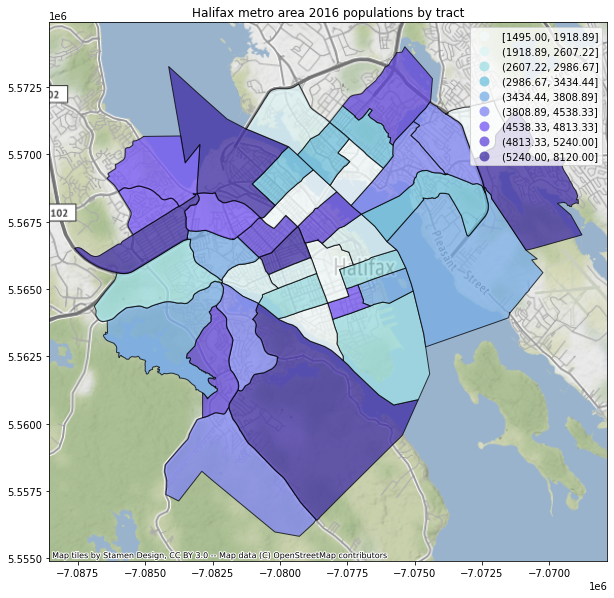

In [141]:
colours = ['#f4fbfc','#ddf3f5', '#9edfe5', '#70c2df', '#77ade6', '#7e84f3', '#7354f4', '#6146d9', '#3f2da5']
cmap = cl.ListedColormap(colours)
fig, ax = plt.subplots(1,1)
fig.set_figheight(10)
fig.set_figwidth(10)
halifax2016.plot(     column='population',
                      ax=ax,
                      scheme='quantiles',
                      k=9,
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap)
ctx.add_basemap(ax, zoom=12)
ax.set_title("Halifax metro area 2016 populations by tract")

###Determine gentrification status from 2006 to 2016 tract data

Tracts are determined to have gentrified over a time period if they meet the following criteria:

1. An increase in a tract's educational attainment, as measured by the percentage of residents age 25 and over holding bachelor’s degrees, is in the top third percentile of all tracts within a metro area.
2. A tract’s home value increases when adjusted for inflation.
3. The percentage increase in a tract’s inflation-adjusted home value is in the top third percentile of all tracts within a metro area.

This measure of gentrification is based on the methodology found at [this link](https://www.governing.com/gov-data/gentrification-report-methodology.html). Halifax metro area calculations necessary for this test are:

1. `educ_eligible`: true if the tract is in the top third percentile of increases in educational attainment from 2006 to 2016.
2. `home_value_increase`: true if a tract's home value increases from 2006 to 2016 when adjusted for inflation.
3. `home_eligible`: true if a tract's percentage of home value increase is in the top third percentile of increases in home value from 2006 to 2016.

If all variables are true for a given tract, it is considered `gentrified`.

In [68]:
census_tracts = pd.DataFrame(columns=['tid','geometry','educ_eligible','home_value_increase','home_eligible', 'gentrified'])
census_tracts['tid'] = halifax2006['tid']
census_tracts['geometry'] = halifax2006['geometry']

####Calculate educational attainment increase

- Find difference in number of people holding bachelor's degrees between 2006 and 2006
- Find 66th percentile among tracts
- Compare each tract against 66th percentile and assign appropriate `educ_eligible` value

In [ ]:
educ2006 = np.array(halifax2006['p_educ'])
educ2016 = np.array(halifax2016['p_educ'])

educ_difference = []
for i in range(len(educ2006)):
  educ_difference.append(educ2016[i] - educ2006[i])
educ_difference = np.array(educ_difference)

min_educ = educ_difference.min()
max_educ = educ_difference.max()
percentile66 = np.percentile(educ_difference, 66)

for i in range(len(census_tracts['tid'])):
  if educ_difference[i] > percentile66:
    census_tracts['educ_eligible'][i] = True
  else:
    census_tracts['educ_eligible'][i] = False

####Calculate increase in home value

- Adjust each home value for inflation between 2006 and 2016
- Assign appropriate `home_value_increase` value
- Find 66th percentile among tracts
- Compare each tract against 66th percentile and assign appropriate `home_eligible` value

In [ ]:
inflation_rate = 1.1777
for i in range(len(halifax2006['tid'])):
  if (halifax2006['home'][i]*inflation_rate) < halifax2016['home'][i]:
    census_tracts['home_value_increase'][i] = True
  else:
    census_tracts['home_value_increase'][i] = False

In [ ]:
home2006 = np.array(halifax2006['home'])
home2016 = np.array(halifax2016['home'])

home_difference = []
for i in range(len(home2006)):
  home_difference.append(home2016[i] - (home2006[i]*inflation_rate))
home_difference = np.array(home_difference)
percentile66 = np.percentile(home_difference, 66)

for i in range(len(census_tracts['tid'])):
  if home_difference[i] > percentile66:
    census_tracts['home_eligible'][i] = True
  else:
    census_tracts['home_eligible'][i] = False

####Determine gentrification status

- If all variables above are true, the tract has been `gentrified`
- Plot eligible tracts

In [ ]:
for i in range(len(census_tracts['tid'])):
  if census_tracts['educ_eligible'][i] == True and census_tracts['home_value_increase'][i] == True and census_tracts['home_eligible'][i] == True:
    census_tracts['gentrified'][i] = True
  else:
    census_tracts['gentrified'][i] = False

Text(0.5, 1.0, 'Determined to have gentrified')

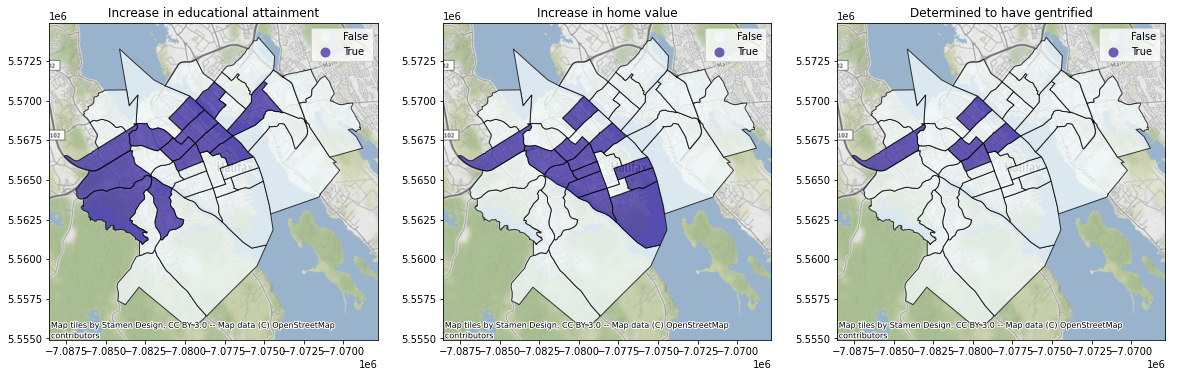

In [75]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
fig.set_figheight(20)
fig.set_figwidth(20)
trcts = gpd.GeoDataFrame(census_tracts, geometry='geometry')
trcts.plot(column='educ_eligible', ax=ax1, edgecolor='k', cmap=cmap,legend=True, alpha=0.75)
trcts.plot(column='home_eligible', ax=ax2, edgecolor='k', cmap=cmap, legend=True, alpha=0.75)
trcts.plot(column='gentrified', ax=ax3, edgecolor='k', cmap=cmap, legend=True, alpha=0.75)
ctx.add_basemap(ax1, zoom=12)
ctx.add_basemap(ax2, zoom=12)
ctx.add_basemap(ax3, zoom=12)
ax1.set_title("Increase in educational attainment")
ax2.set_title("Increase in home value")
ax3.set_title("Determined to have gentrified")

###Graphs of demographic data

In [119]:
cmap1 = cl.ListedColormap(colours[0:9])
cmap2 = cl.ListedColormap(colours[0:7])
cmap3 = cl.ListedColormap(colours[0:6])
cmap4 = cl.ListedColormap(colours[0:5])
cmap5 = cl.ListedColormap(colours[0:4])

####Black population



Text(0.5, 1.0, '2016 Black population')

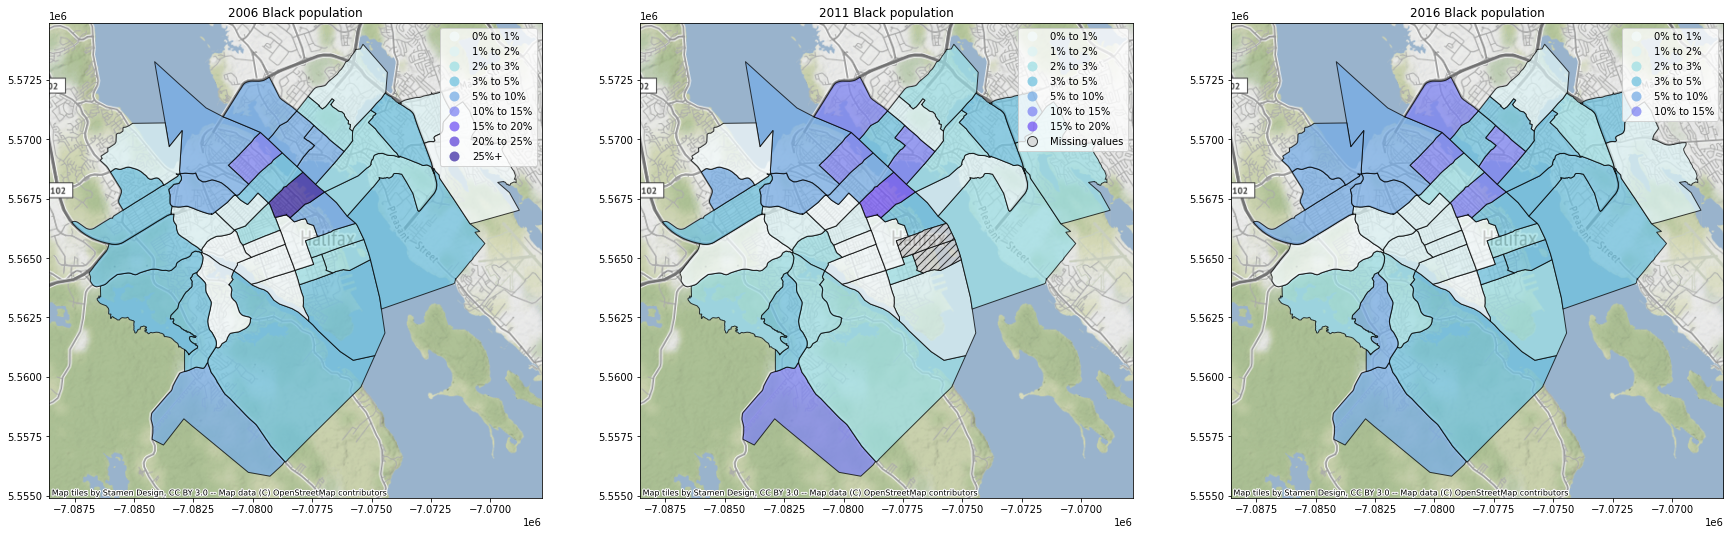

In [101]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(30)
halifax2006.plot(     column='p_black',
                      ax=ax1,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.01,0.02,0.03,0.05,0.1,0.15,0.2,0.25,0.3]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap1)
ctx.add_basemap(ax1, zoom=12)
labels1=["0% to 1%", "1% to 2%", "2% to 3%", "3% to 5%", "5% to 10%", "10% to 15%", "15% to 20%", "20% to 25%", "25%+"]
leg1 = ax1.get_legend()
for text, label in zip(leg1.get_texts(), labels1):
    text.set_text(label)
ax1.set_title("2006 Black population")

halifax2011.plot(     column='p_black',
                      ax=ax2, 
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.01,0.02,0.03,0.05,0.1,0.15,0.2]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      missing_kwds={ "color": "lightgrey", "hatch": "///", "label": "Missing values", },
                      cmap=cmap2)
ctx.add_basemap(ax2, zoom=12)
labels2=["0% to 1%", "1% to 2%", "2% to 3%", "3% to 5%", "5% to 10%", "10% to 15%", "15% to 20%"]
leg2 = ax2.get_legend()
for text, label in zip(leg2.get_texts(), labels2):
    text.set_text(label)
ax2.set_title("2011 Black population")

halifax2016.plot(     column='p_black',
                      ax=ax3, 
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.01,0.02,0.03,0.05,0.1,0.16]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap3)
ctx.add_basemap(ax3, zoom=12)
labels3=["0% to 1%", "1% to 2%", "2% to 3%", "3% to 5%", "5% to 10%", "10% to 15%"]
leg3 = ax3.get_legend()
for text, label in zip(leg3.get_texts(), labels3):
    text.set_text(label)
ax3.set_title("2016 Black population")

####Indigenous population

Text(0.5, 1.0, '2016 Indigenous population')

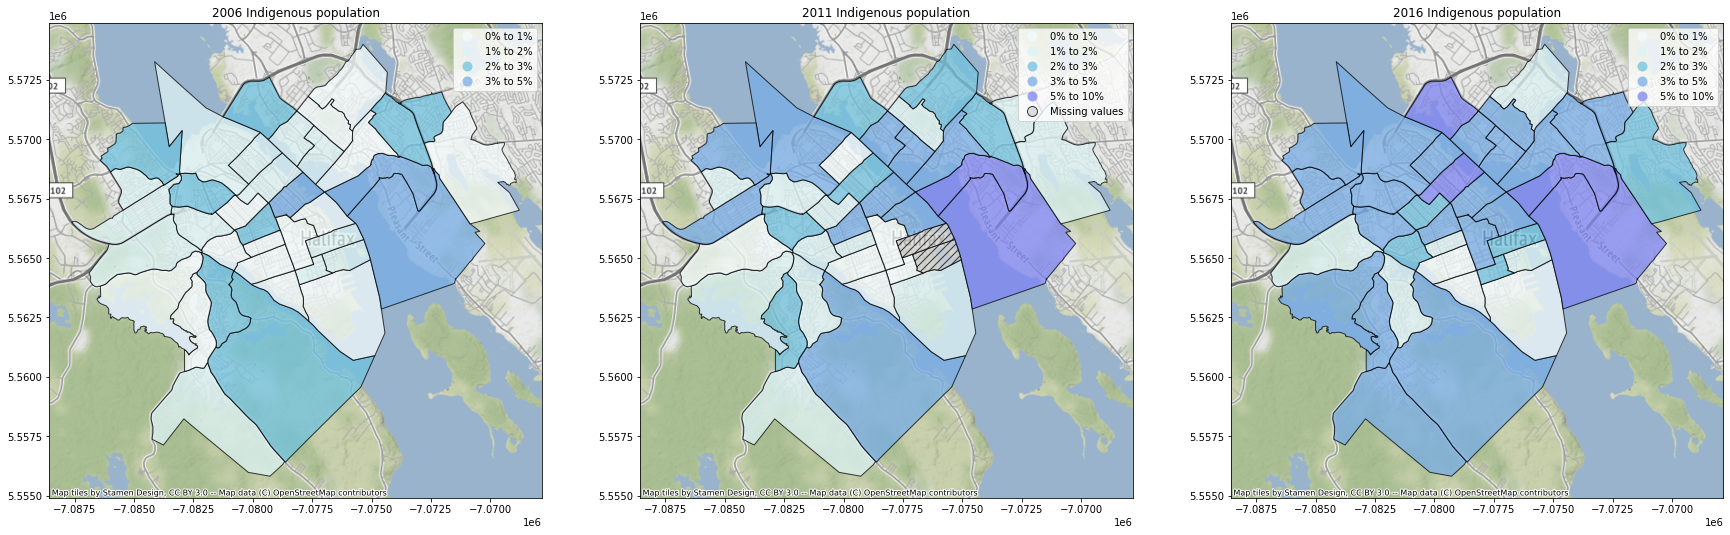

In [122]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(30)
halifax2006.plot(     column='p_indig',
                      ax=ax1,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.01,0.02,0.03,0.05]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap4)
ctx.add_basemap(ax1, zoom=12)
labels1=["0% to 1%", "1% to 2%", "2% to 3%", "3% to 5%"]
leg1 = ax1.get_legend()
for text, label in zip(leg1.get_texts(), labels1):
    text.set_text(label)
ax1.set_title("2006 Indigenous population")

halifax2011.plot(     column='p_indig',
                      ax=ax2, 
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.01,0.02,0.03,0.05,0.10]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      missing_kwds={ "color": "lightgrey", "hatch": "///", "label": "Missing values", },
                      cmap=cmap3)
ctx.add_basemap(ax2, zoom=12)
labels2=["0% to 1%", "1% to 2%", "2% to 3%", "3% to 5%", "5% to 10%"]
leg2 = ax2.get_legend()
for text, label in zip(leg2.get_texts(), labels2):
    text.set_text(label)
ax2.set_title("2011 Indigenous population")

halifax2016.plot(     column='p_indig',
                      ax=ax3, 
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.01,0.02,0.03,0.05,0.10]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap3)
ctx.add_basemap(ax3, zoom=12)
labels3=["0% to 1%", "1% to 2%", "2% to 3%", "3% to 5%", "5% to 10%"]
leg3 = ax3.get_legend()
for text, label in zip(leg3.get_texts(), labels3):
    text.set_text(label)
ax3.set_title("2016 Indigenous population")

####Asian population

Text(0.5, 1.0, '2016 Asian population')

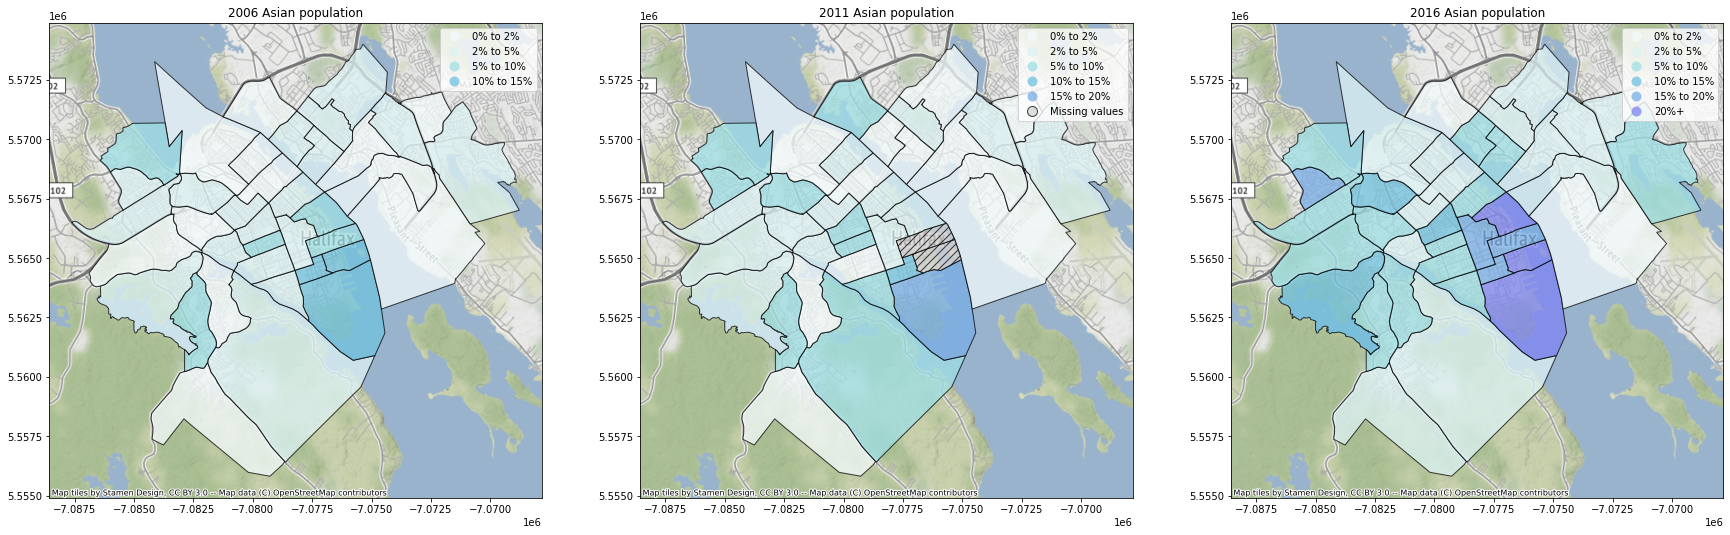

In [126]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(30)
halifax2006.plot(     column='p_asian',
                      ax=ax1,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.02,0.05,0.10,0.15]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap5)
ctx.add_basemap(ax1, zoom=12)
labels1=["0% to 2%", "2% to 5%", "5% to 10%", "10% to 15%"]
leg1 = ax1.get_legend()
for text, label in zip(leg1.get_texts(), labels1):
    text.set_text(label)
ax1.set_title("2006 Asian population")

halifax2011.plot(     column='p_asian',
                      ax=ax2,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.02,0.05,0.10,0.15,0.20]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      missing_kwds={ "color": "lightgrey", "hatch": "///", "label": "Missing values", },
                      cmap=cmap4)
ctx.add_basemap(ax2, zoom=12)
labels2=["0% to 2%", "2% to 5%", "5% to 10%", "10% to 15%", "15% to 20%"]
leg2 = ax2.get_legend()
for text, label in zip(leg2.get_texts(), labels2):
    text.set_text(label)
ax2.set_title("2011 Asian population")

halifax2016.plot(     column='p_asian',
                      ax=ax3,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.02,0.05,0.10,0.15,0.20,0.25]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap3)
ctx.add_basemap(ax3, zoom=12)
labels3=["0% to 2%", "2% to 5%", "5% to 10%", "10% to 15%", "15% to 20%", "20%+"]
leg3 = ax3.get_legend()
for text, label in zip(leg3.get_texts(), labels3):
    text.set_text(label)
ax3.set_title("2016 Asian population")

####Minority population

Text(0.5, 1.0, '2016 minority population')

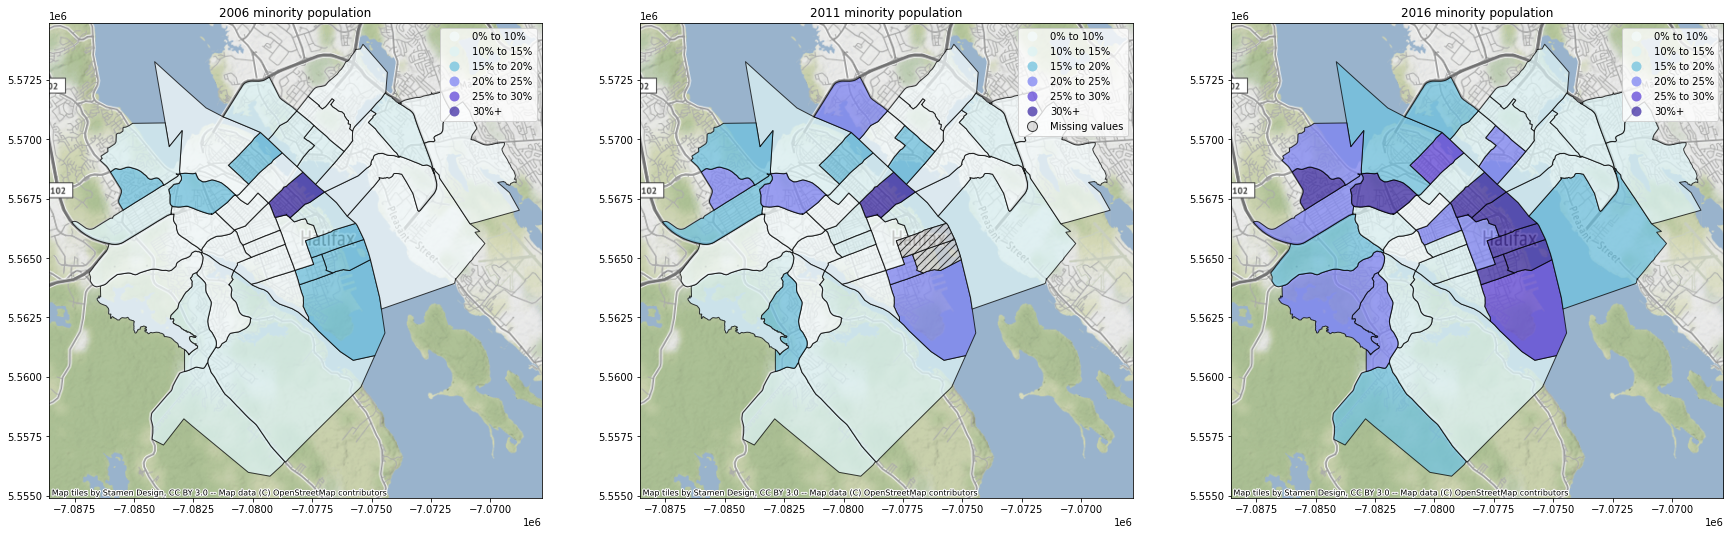

In [142]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(30)
halifax2006.plot(     column='p_poc',
                      ax=ax1,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.10,0.15,0.20,0.25,0.30]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap1)
ctx.add_basemap(ax1, zoom=12)
labels1=["0% to 10%", "10% to 15%", "15% to 20%", "20% to 25%", "25% to 30%", "30%+"]
leg1 = ax1.get_legend()
for text, label in zip(leg1.get_texts(), labels1):
    text.set_text(label)
ax1.set_title("2006 minority population")

halifax2011.plot(     column='p_poc',
                      ax=ax2,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.10,0.15,0.20,0.25,0.30]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      missing_kwds={ "color": "lightgrey", "hatch": "///", "label": "Missing values", },
                      cmap=cmap1)
ctx.add_basemap(ax2, zoom=12)
labels2=["0% to 10%", "10% to 15%", "15% to 20%", "20% to 25%", "25% to 30%", "30%+"]
leg2 = ax2.get_legend()
for text, label in zip(leg2.get_texts(), labels2):
    text.set_text(label)
ax2.set_title("2011 minority population")

halifax2016.plot(     column='p_poc',
                      ax=ax3,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.10,0.15,0.20,0.25,0.30]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap1)
ctx.add_basemap(ax3, zoom=12)
labels3=["0% to 10%", "10% to 15%", "15% to 20%", "20% to 25%", "25% to 30%", "30%+"]
leg3 = ax3.get_legend()
for text, label in zip(leg3.get_texts(), labels3):
    text.set_text(label)
ax3.set_title("2016 minority population")

####Cost of rented dwellings adjusted for inflation

In [ ]:
# Adjusting rent values for inflation from 2006-2016 and 2011-2016
inflation0616 = 1.1777
inflation1116 = 1.0637
for i in range(len(halifax2006['rent'])):
  halifax2006['rent'][i] = halifax2006['rent'][i]*inflation0616
  halifax2011['rent'][i] = halifax2011['rent'][i]*inflation1116

Text(0.5, 1.0, '2016 monthly rent')

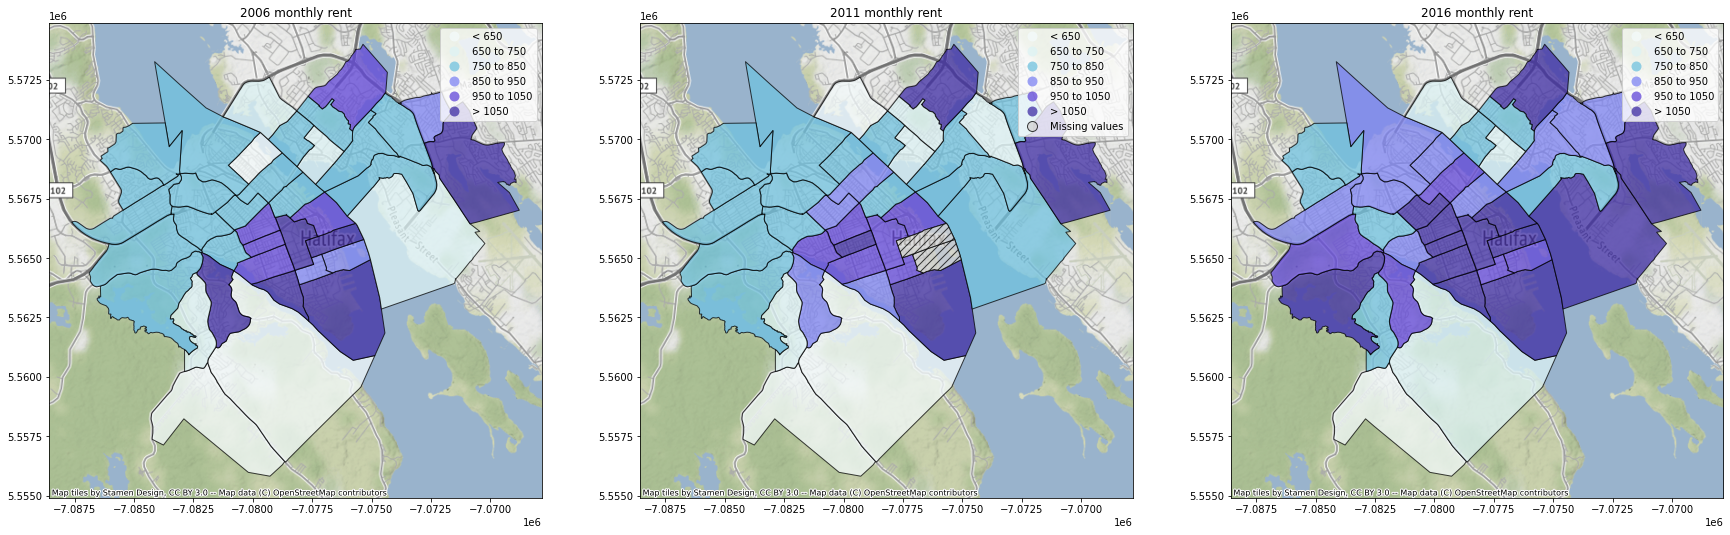

In [146]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(30)
halifax2006.plot(     column='rent',
                      ax=ax1,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[650,750,850,950,1050]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap1)
ctx.add_basemap(ax1, zoom=12)
labels1=["< 650", "650 to 750", "750 to 850", "850 to 950", "950 to 1050", "> 1050"]
leg1 = ax1.get_legend()
for text, label in zip(leg1.get_texts(), labels1):
    text.set_text(label)
ax1.set_title("2006 monthly rent")

halifax2011.plot(     column='rent',
                      ax=ax2,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[650,750,850,950,1050]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      missing_kwds={ "color": "lightgrey", "hatch": "///", "label": "Missing values", },
                      cmap=cmap1)
ctx.add_basemap(ax2, zoom=12)
labels2=["< 650", "650 to 750", "750 to 850", "850 to 950", "950 to 1050", "> 1050"]
leg2 = ax2.get_legend()
for text, label in zip(leg2.get_texts(), labels2):
    text.set_text(label)
ax2.set_title("2011 monthly rent")

halifax2016.plot(     column='rent',
                      ax=ax3,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[650,750,850,950,1050]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap1)
ctx.add_basemap(ax3, zoom=12)
labels3=["< 650", "650 to 750", "750 to 850", "850 to 950", "950 to 1050", "> 1050"]
leg3 = ax3.get_legend()
for text, label in zip(leg3.get_texts(), labels3):
    text.set_text(label)
ax3.set_title("2016 monthly rent")

####Cost of owned dwellings adjusted for inflation

In [ ]:
# Adjusting home values for inflation from 2006-2016 and 2011-2016
for i in range(len(halifax2006['home'])):
  halifax2006['home'][i] = halifax2006['home'][i]*inflation0616
  halifax2011['home'][i] = halifax2011['home'][i]*inflation1116

Text(0.5, 1.0, '2016 home value')

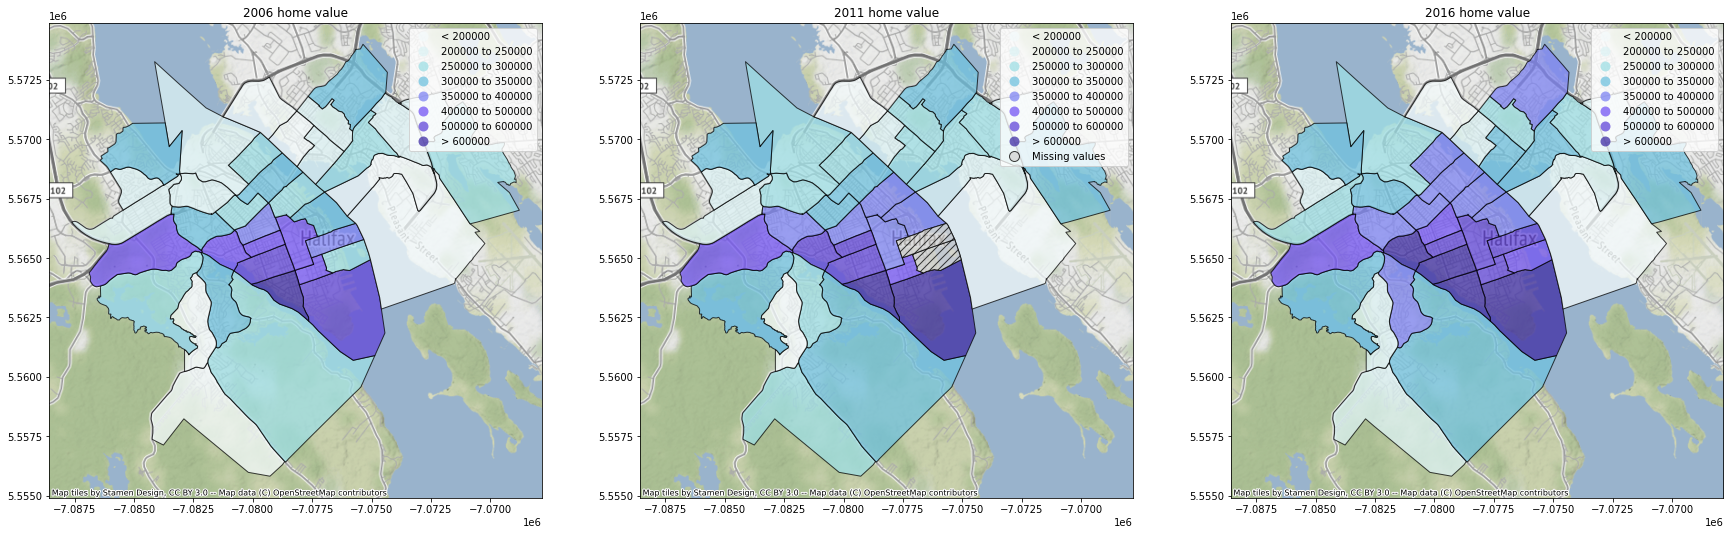

In [154]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(30)
halifax2006.plot(     column='home',
                      ax=ax1,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[200000,250000,300000,350000,400000,500000,600000]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap)
ctx.add_basemap(ax1, zoom=12)
labels1=["< 200000", "200000 to 250000", "250000 to 300000", "300000 to 350000", "350000 to 400000", "400000 to 500000", "500000 to 600000", "> 600000"]
leg1 = ax1.get_legend()
for text, label in zip(leg1.get_texts(), labels1):
    text.set_text(label)
ax1.set_title("2006 home value")

halifax2011.plot(     column='home',
                      ax=ax2,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[200000,250000,300000,350000,400000,500000,600000]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      missing_kwds={ "color": "lightgrey", "hatch": "///", "label": "Missing values", },
                      cmap=cmap)
ctx.add_basemap(ax2, zoom=12)
labels2=["< 200000", "200000 to 250000", "250000 to 300000", "300000 to 350000", "350000 to 400000", "400000 to 500000", "500000 to 600000", "> 600000"]
leg2 = ax2.get_legend()
for text, label in zip(leg2.get_texts(), labels2):
    text.set_text(label)
ax2.set_title("2011 home value")

halifax2016.plot(     column='home',
                      ax=ax3,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[200000,250000,300000,350000,400000,500000,600000]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap)
ctx.add_basemap(ax3, zoom=12)
labels3=["< 200000", "200000 to 250000", "250000 to 300000", "300000 to 350000", "350000 to 400000", "400000 to 500000", "500000 to 600000", "> 600000"]
leg3 = ax3.get_legend()
for text, label in zip(leg3.get_texts(), labels3):
    text.set_text(label)
ax3.set_title("2016 home value")

####Educational attainment

Text(0.5, 1.0, '2016 educational attainment')

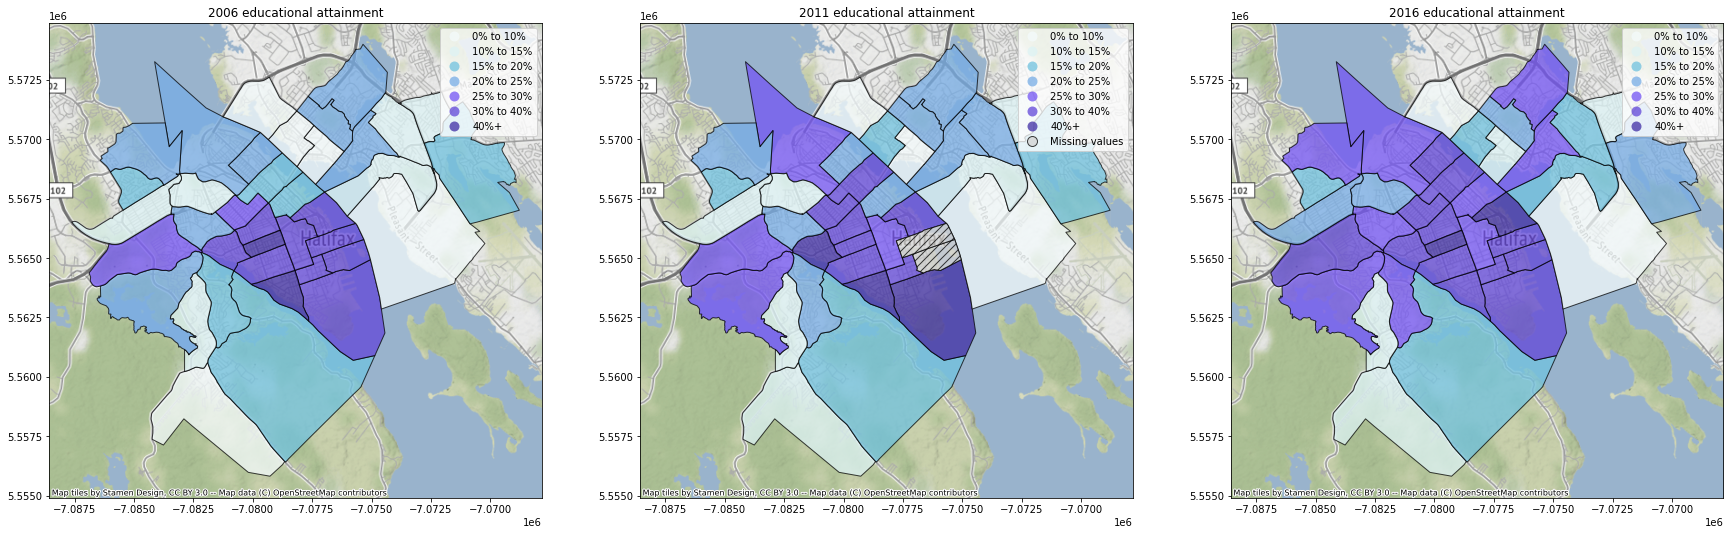

In [159]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(30)
halifax2006.plot(     column='p_educ',
                      ax=ax1,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.1,0.15,0.2,0.25,0.3,0.4]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap)
ctx.add_basemap(ax1, zoom=12)
labels1=["0% to 10%", "10% to 15%", "15% to 20%", "20% to 25%", "25% to 30%", "30% to 40%", "40%+"]
leg1 = ax1.get_legend()
for text, label in zip(leg1.get_texts(), labels1):
    text.set_text(label)
ax1.set_title("2006 educational attainment")

halifax2011.plot(     column='p_educ',
                      ax=ax2,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.1,0.15,0.2,0.25,0.3,0.4]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      missing_kwds={ "color": "lightgrey", "hatch": "///", "label": "Missing values", },
                      cmap=cmap)
ctx.add_basemap(ax2, zoom=12)
labels2=["0% to 10%", "10% to 15%", "15% to 20%", "20% to 25%", "25% to 30%", "30% to 40%", "40%+"]
leg2 = ax2.get_legend()
for text, label in zip(leg2.get_texts(), labels2):
    text.set_text(label)
ax2.set_title("2011 educational attainment")

halifax2016.plot(     column='p_educ',
                      ax=ax3,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.1,0.15,0.2,0.25,0.3,0.4]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap)
ctx.add_basemap(ax3, zoom=12)
labels3=["0% to 10%", "10% to 15%", "15% to 20%", "20% to 25%", "25% to 30%", "30% to 40%", "40%+"]
leg3 = ax3.get_legend()
for text, label in zip(leg3.get_texts(), labels3):
    text.set_text(label)
ax3.set_title("2016 educational attainment")